# PitchBERT: Categorizing early stage startup pitchdecks with an LLM

📌 *Overview*

This Jupyter Notebook demonstrates the steps to preprocess, train, and evaluate a text classification model utilizing the BERT-base uncased transformer model from the HuggingFace library. The end goal is to categorize pitch decks into one of the four categories: Public, Acquired, Venture, or Closed.

📂 *Key Steps & Highlights*

**1. Data Loading and Preprocessing:**

📁 Text data and labels are **loaded from a local directory** where each directory's name serves as an indicative label, encompassing the text files within.

🧩 A **token-level chunking approach** ensures that texts remain within the BERT's token threshold. This is done to avert truncation and potential loss of context and information, while accommodating the overlap between chunks.

🗳️ A **majority voting mechanism** is used to consolidate the predictions made on the individual chunks into predictions for the complete pitch deck. The mechanism is **"first-past-the-goalpost"**, so the highest number of votes always determines the prediction for the pitch deck.

**2. Tokenization:**

📖 Utilizing **BertTokenizer.from_pretrained('bert-base-uncased')**, texts are transformed into a tokenized format, priming them for BERT training.

**3. Model Training:**

🚀 The model, **TFBertForSequenceClassification**, undergoes fine-tuning on the dataset for 50 epochs.

🛠️ The **legacy Adam optimizer** is used because the model is being trained on an M2 MacBook Pro and there are known performance issues with the current version of the Adam optimizer and this hardware. 

✅ **Validation was completely removed** and thus there is no train/test split in the model. This was done to accommodate the limited data set available for training. 


**4. Evaluation:**

📊 **Accuracy and loss graphs** shed light on the model's training trajectory over epochs.

🔍 A **confusion matrix** highlights the model's ability in classifying pitch decks correctly among the designated categories.

In [1]:
# importing dependencies for file access, model, visualisations, and other utilities
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random

from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.math import confusion_matrix
from collections import Counter

In [2]:
def load_data_from_directory(base_dir):
    """
    Load data and integer labels from the directory structure.

    Parameters:
    - base_dir: The directory containing label-based subdirectories

    Returns:
    - texts: A list of texts from the files
    - labels: A corresponding list of integer labels
    """
    texts = []
    labels = []

    # Loop through each directory in the base directory
    for label_dir in os.listdir(base_dir):
        # Ensure it's actually a directory
        if os.path.isdir(os.path.join(base_dir, label_dir)):
            # Extract label from the directory name (here we extract the prefixing number)
            label_int = int(label_dir.split('_')[0]) - 1  # subtracting 1 to make labels start from 0

            # Loop through each file in the directory
            for filename in os.listdir(os.path.join(base_dir, label_dir)):
                if filename.endswith(".txt"):
                    with open(os.path.join(base_dir, label_dir, filename), 'r', encoding='utf-8') as file:
                        texts.append(file.read())
                        labels.append(label_int)

    return texts, labels

base_dir = "/Users/jeromejaggi/Desktop/MSc Dissertation/6_Data"
texts, labels = load_data_from_directory(base_dir)
print("✅ Loaded", len(texts), "documents.")

✅ Loaded 51 documents.


In [3]:
# Create a DataFrame from the lists tesxts and labels 
df = pd.DataFrame({
    'Text': texts,
    'Label': labels
})

# Display the first few rows of the DataFrame to show data
print(df.head())

                                                Text  Label
0  NVISION\n\nMetabolic MRI agents\nA powerful ne...      1
1  Sherpa\nEasy eVisas.\nJanuary, 2019\n\n\nJUL 2...      1
2  honey\n\nPROBLEM:\nIn 2014,143.2 million onlin...      1
3  arcus\nthe new infrastructure for recurring pa...      1
4  cheuise\nBig groups. Big meals. Thousands fed....      1


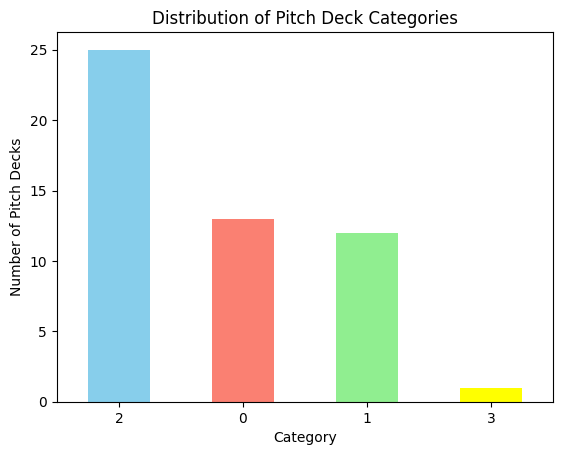

In [4]:
# Convert labels to a pandas Series for easier counting
labels_series = pd.Series(labels)

# Plotting the distribution
labels_series.value_counts().plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen', 'yellow'])
plt.title('Distribution of Pitch Deck Categories')
plt.xlabel('Category')
plt.ylabel('Number of Pitch Decks')
plt.xticks(rotation=0)
plt.show()

The dataset consists of 51 seed pitch decks for startups that fulfill the following criteria:

1. The company had to be at least 7 years old as of 23.06.2023
2. The company's seed deck had to be available (no further rounds taken into account)
3. The company's information had to be available on https://www.crunchbase.com, to obtain information about their current status which was then turned into one of the labels (Public, Acquired, Venture, Closed).

Visualizing the data distribution shows a very skewed dataset where "venture" stage pitch decks are heavily overrepresented. The data was obtained from two sources:

[1] 31 pitch decks were extracted from the professional venture capital database angelmatch.io (https://angelmatch.io)
[2] 20 pitch decks were extracted from the publicly available pitch deck database compiled by Houck (https://airtable.com/app3eaZhwxrbyz20l/shrsHNEj7ghPBpuvw/tblgdUT6MWurBGgMJ)


Key to the labels:
0: Public, 1: Acquired, 2: Venture, 3: Closed

In [5]:
# Set seeds for more consistent model training accross different runs
SEED = 42

random.seed(SEED)  # Python
np.random.seed(SEED)  # NumPy
tf.random.set_seed(SEED)  # Tensorflow

In [6]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def chunk_text(text, max_length=510, overlap=50):
    """
    Breaks a text into chunks that fit within a specified maximum length, with an option to overlap the chunks.

    Parameters:
    - text (str): The input text that needs to be chunked.
    - max_length (int, optional): The maximum length for each chunk. Default is 510 tokens.
    - overlap (int, optional): The number of tokens by which chunks overlap. Default is 50 tokens.

    Returns:
    - list[str]: A list of text chunks.
    """
    
    # Tokenize the text into words/tokens using the tokenizer
    words = tokenizer.tokenize(text)
    
    # List to store the chunks of text
    chunks = []
    
    # Continue processing while there are words left in the list
    while words:
        
        # Temporary list to store words for the current chunk
        chunk = []
        
        # Add words to the current chunk until adding another word would exceed the maximum chunk length (accounting for overlap)
        while words and len(chunk) + len(words[0]) <= max_length - overlap:
            word = words.pop(0)  # Remove and get the first word from the list
            chunk.append(word)
        
        # Convert the chunk's tokens back to a string and add to the chunks list
        chunks.append(tokenizer.convert_tokens_to_string(chunk))
    
    return chunks


# Chunk the texts
chunked_texts = [chunk_text(text) for text in texts]

# Flatten the chunked_texts and labels for training
flat_texts = [chunk for doc in chunked_texts for chunk in doc]
flat_labels = [label for label, doc in zip(labels, chunked_texts) for chunk in doc]

# Convertig flattened labels to numpy array to comply with model requirements
flat_labels = np.array(flat_labels)


# Tokenize the chunked texts
encoded_texts = tokenizer(flat_texts, truncation=True, padding=True, max_length=512, return_tensors='tf')

print("Total chunks created:", len(flat_texts))

# Show the first 5 junks to get an understanding of the data
print("\nChunked Texts:")
print("-" * 50)
for i, chunk in enumerate(flat_texts[:5], 1):
    print(f"Chunk {i}:")
    print(chunk)
    print("-" * 50)

Total chunks created: 143

Chunked Texts:
--------------------------------------------------
Chunk 1:
nvision metabolic mri agents a powerful new weapon in the war against cancer july 2022 key challenge facing oncologists : lack of timely feedback on the effectiveness of therapy for example : in neoadjuvant therapy drugs are given for months before surgical extraction of the tumor . yet , only 20 - 40 % of cancer patients achieve the desired response to this therapy . the remainder of patients continue to receive ineffective treatment for months , suffer from poorer long - term outcomes and toxic effects . diagnose , search for marker / s is it working ? months . . . start several cycles of treatment ch objective response based on imaging / surgery confidential & proprietary nvision ' s technology enables unprecedented early insight to whether cancer treatment is working or not effective treatment induces immediate metabolic response in tumors , months before visible macroscopic change

2023-08-18 19:03:23.084029: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-08-18 19:03:23.084056: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-08-18 19:03:23.084065: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-08-18 19:03:23.084096: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-18 19:03:23.084118: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Text chunking was done to ensure entire pitch decks can be passed to the model, regardless of length of the pitch deck text (which often exceeds the max_token_length of 512 limitation that BERT has).

Based on:
https://towardsdatascience.com/how-to-chunk-text-data-a-comparative-analysis-3858c4a0997a

In [7]:
# Model Configuration and Compilation
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(labels)))
optimizer = Adam(learning_rate=5e-6, epsilon=1e-08)
loss = 'sparse_categorical_crossentropy'
metric = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metric)

# Training on Entire Dataset (without validation)
history = model.fit(encoded_texts['input_ids'], flat_labels, epochs=50, batch_size=16)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/50


2023-08-18 19:03:31.788608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 199s 15s/step - loss: 6.0112 - accuracy: 0.1189
Epoch 2/50
9/9 [==============================] - 13s 1s/step - loss: 2.7721 - accuracy: 0.3427
Epoch 3/50
9/9 [==============================] - 13s 1s/step - loss: 1.4588 - accuracy: 0.3986
Epoch 4/50
9/9 [==============================] - 13s 1s/step - loss: 1.2935 - accuracy: 0.4126
Epoch 5/50
9/9 [==============================] - 13s 1s/step - loss: 1.2918 - accuracy: 0.4196
Epoch 6/50
9/9 [==============================] - 13s 1s/step - loss: 1.2978 - accuracy: 0.4406
Epoch 7/50
9/9 [==============================] - 14s 2s/step - loss: 1.2569 - accuracy: 0.4196
Epoch 8/50
9/9 [==============================] - 13s 1s/step - loss: 1.2748 - accuracy: 0.4336
Epoch 9/50
9/9 [==============================] - 14s 1s/step - loss: 1.2798 - accuracy: 0.4266
Epoch 10/50
9/9 [==============================] - 14s 2s/step - loss: 1.2803 - accuracy: 0.4685
Epoch 11/50
9/9 [==============================]

The legacy Adam optimizer is used because the model is being trained on an M2 MacBook Pro and there are known performance issues with the current version of the Adam optimizer and this hardware.

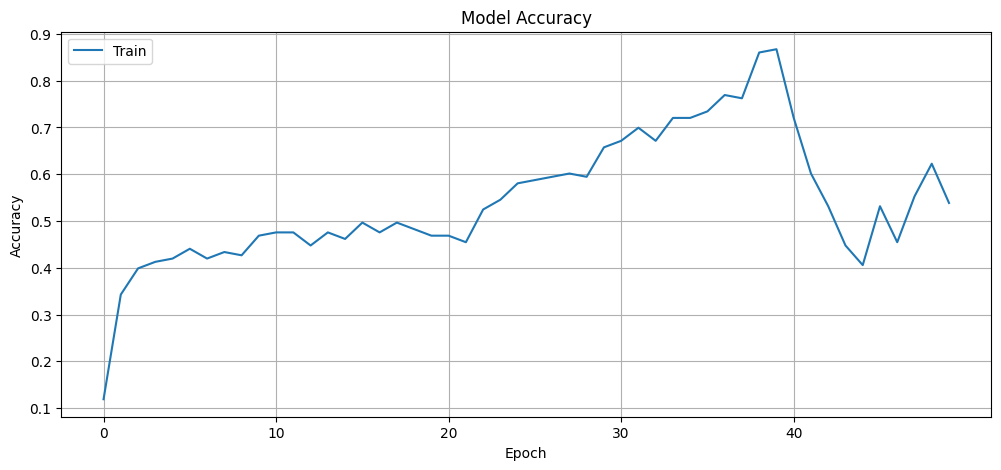

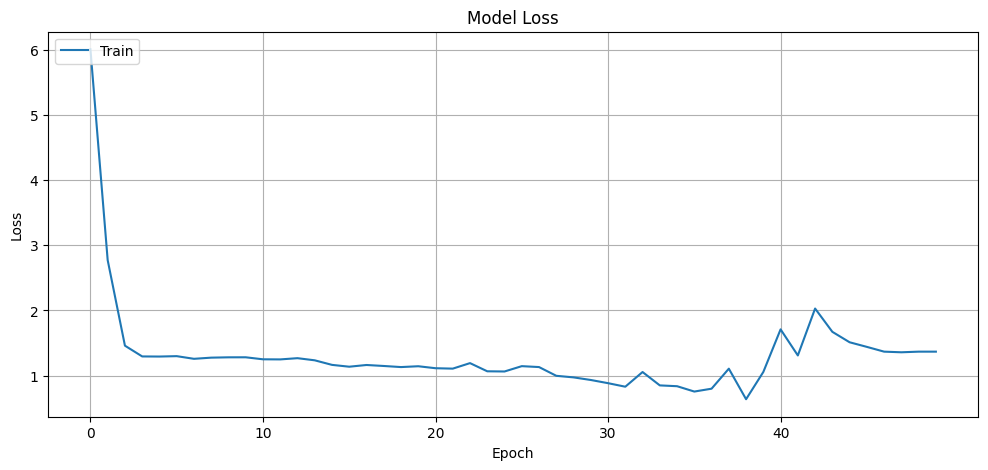

In [8]:
# Plotting accuracy and loss to show performance
STEP=10

# Plotting accuracy

plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, len(history.history['accuracy']), step=STEP))
plt.legend(['Train'], loc='upper left')
plt.grid(True)
plt.show()

# Plotting loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, len(history.history['loss']), step=STEP)) 
plt.legend(['Train'], loc='upper left')
plt.grid(True)
plt.show()

Model accuracy seems to be increasing steadily over the course of 50 epochs but this is very likely due to heavy over fitting. Loss seems to stabilize quickly at acceptable rates but there is probably over fitting because loss is not validated either. 

In [9]:
# Defining a helper function to to majority voting on the chunk predictions.
def majority_vote_for_deck(chunked_texts, y_pred):
    """
    Given chunked texts and their predictions, apply majority voting ("First past the goal post")
    to get the predicted label for each original document. Ties will be handled by taking the first prediction
    the model made.
    """
    doc_predictions = []
    start_index = 0  # Initialize the start_index variable here

    for doc_chunks in chunked_texts:
        num_chunks = len(doc_chunks)
        
        # Get the predictions for the chunks of the current document
        current_preds = y_pred[start_index:start_index + num_chunks]
        
        # Apply majority voting
        most_common_label, _ = Counter(current_preds).most_common(1)[0]
        doc_predictions.append(most_common_label)
        
        # Update the start index for the next document
        start_index += num_chunks
        
    return doc_predictions

The voting mechanism is introduced here to consolidate the predictions the model made on the chunks into one single prediction for the entire pitch deck.

Based on: https://machinelearningmastery.com/voting-ensembles-with-python/

In [10]:
# Data preparation for and computing of a confusion matrix.

# Getting the logits (predictions before activation) for the entire dataset
logits = model.predict(encoded_texts['input_ids'])

# Extracting predictions from the model's output
y_pred = np.argmax(logits.logits, axis=-1)

# Set true_labels_per_document based on the assumption that 'labels' are for entire pitch decks
true_labels_per_document = labels

# Use the majority_vote_for_document function to get the predicted labels for each entire pitch deck
document_predictions = majority_vote_for_deck(chunked_texts, y_pred)

# Compute the confusion matrix for the entire pitch decks
cm = confusion_matrix(true_labels_per_document, document_predictions)

# Mapping the int labels to human-readable labels
label_map = {0: "Public", 1: "Acquired", 2: "Venture", 3: "Closed"}
y_true_names = [label_map[label] for label in true_labels_per_document]
y_pred_names = [label_map[label] for label in document_predictions]


2023-08-18 19:18:24.137670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 59s 6s/step


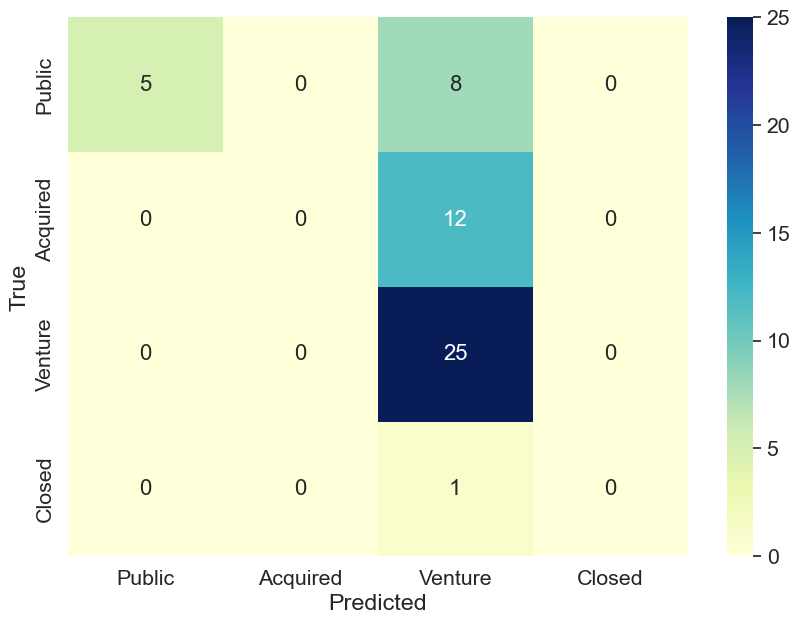

In [11]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap="YlGnBu",
            xticklabels=['Public', 'Acquired', 'Venture', 'Closed'], 
            yticklabels=['Public', 'Acquired', 'Venture', 'Closed'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

The confusion matrix shows good performance when predicting true positives for venture and public decks and worse performance for acquired and closed. This is in line with expectations because of the heavily skewed dataset. It is very likely that the model over fits on the training data because there is no validation or test/train split.

Based on:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html